<a href="https://colab.research.google.com/github/Mehak3412/TrueVision/blob/main/currency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics albumentations opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
from glob import glob
import zipfile
import gdown
import os

# Step 1: Download the zip file from Google Drive
file_id = "1IC84sogPwmcogaSwxXkUAjOVlWuk_KZC"

url = f"https://drive.google.com/uc?id={file_id}"
output = "Dataset_real_currency.zip"
gdown.download(url, output, quiet=False)
print(f"File downloaded and saved as: {output}")

# 2️Check if file downloaded
if os.path.exists(output):
    print(f" File downloaded: {output}")
else:
    raise FileNotFoundError(f" Download failed: {output}")

# 3️Unzip
extract_path = "Dataset_real"
try:
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f" Dataset extracted to: {extract_path}")
except zipfile.BadZipFile:
    raise Exception(" The file is not a valid zip archive or is corrupted.")

!ls Dataset_real
!ls Dataset_real/cleaned_dataset/train
!ls Dataset_real/cleaned_dataset/test
!ls Dataset_real/cleaned_dataset/val

Downloading...
From (original): https://drive.google.com/uc?id=1IC84sogPwmcogaSwxXkUAjOVlWuk_KZC
From (redirected): https://drive.google.com/uc?id=1IC84sogPwmcogaSwxXkUAjOVlWuk_KZC&confirm=t&uuid=543ed19b-3c3e-4f03-9da3-db3ce5e95217
To: /content/Dataset_real_currency.zip
100%|██████████| 47.9M/47.9M [00:01<00:00, 47.2MB/s]


File downloaded and saved as: Dataset_real_currency.zip
 File downloaded: Dataset_real_currency.zip
 Dataset extracted to: Dataset_real
cleaned_dataset
images	labels	labels.cache
images	labels
images	labels	labels.cache


In [ ]:
import os, cv2, albumentations as A, shutil, random
from glob import glob
from tqdm import tqdm

# ---------------- PARAMETERS ----------------
TARGET_COUNT = 500       # max images per class in TRAIN
VAL_SPLIT_RATIO = 0.15   # 15% into validation
MIN_VAL_IMAGES = 5       # min validation images per class

train_images_dir = "Dataset_real/cleaned_dataset/train/images"
train_labels_dir = "Dataset_real/cleaned_dataset/train/labels"
val_images_dir = "Dataset_real/cleaned_dataset/val/images"
val_labels_dir = "Dataset_real/cleaned_dataset/val/labels"

# Ensure val directories exist
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# ---------------- AUGMENTATION ----------------
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.GaussNoise(p=0.3),
    A.MotionBlur(p=0.3)
])

# ---------------- COUNT IMAGES PER CLASS ----------------
class_images = {}
label_files = glob(os.path.join(train_labels_dir, "*.txt"))

for label_file in label_files:
    with open(label_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = line.split()[0]
            if class_id not in class_images:
                class_images[class_id] = []
            base_name = os.path.basename(label_file).replace(".txt", "")
            img_path_jpg = os.path.join(train_images_dir, f"{base_name}.jpg")
            img_path_png = os.path.join(train_images_dir, f"{base_name}.png")

            if os.path.exists(img_path_jpg):
                class_images[class_id].append((img_path_jpg, label_file))
            elif os.path.exists(img_path_png):
                class_images[class_id].append((img_path_png, label_file))

print("Class distribution before balancing:", {k: len(v) for k,v in class_images.items()})

# ---------------- BALANCE TRAINING DATA ----------------
balanced_class_images = {}

for class_id, images in class_images.items():
    current_count = len(images)

    if current_count < TARGET_COUNT:
        extra_needed = TARGET_COUNT - current_count
        print(f"Augmenting class {class_id} (+{extra_needed}) to {TARGET_COUNT}")
        for i in tqdm(range(extra_needed), desc=f"Class {class_id} augment"):
            img_path, label_file = random.choice(images)
            img = cv2.imread(img_path)
            if img is None:
                continue
            augmented = augment(image=img)
            aug_img = augmented["image"]

            base_name = os.path.basename(img_path).split(".")[0]
            new_img_name = f"{base_name}_aug{i}.jpg"
            new_label_name = f"{base_name}_aug{i}.txt"

            cv2.imwrite(os.path.join(train_images_dir, new_img_name), aug_img)
            shutil.copy(label_file, os.path.join(train_labels_dir, new_label_name))
            images.append((os.path.join(train_images_dir, new_img_name),
                           os.path.join(train_labels_dir, new_label_name)))

    elif current_count > TARGET_COUNT:
        print(f"Reducing class {class_id} ({current_count}→{TARGET_COUNT})")
        to_keep = random.sample(images, TARGET_COUNT)
        to_remove = [item for item in images if item not in to_keep]
        for img_path, label_file in tqdm(to_remove, desc=f"Class {class_id} reduce"):
            try:
                if os.path.exists(img_path): os.remove(img_path)
                if os.path.exists(label_file): os.remove(label_file)
            except Exception as e:
                print(f"Error removing {img_path}: {e}")
        images = to_keep

    # Final balanced list for this class
    balanced_class_images[class_id] = images[:TARGET_COUNT]

print("Balancing complete:", {k: len(v) for k,v in balanced_class_images.items()})

# ---------------- CREATE VALIDATION SPLIT ----------------
for class_id, images in balanced_class_images.items():
    num_val = max(MIN_VAL_IMAGES, int(TARGET_COUNT * VAL_SPLIT_RATIO))
    selected_for_val = random.sample(images, num_val)

    print(f"Class {class_id}: {TARGET_COUNT} total → {num_val} val, {TARGET_COUNT-num_val} train")

    for i, (img_path, label_path) in enumerate(selected_for_val):
        img = cv2.imread(img_path)
        if img is None:
            continue

        base_name = os.path.basename(img_path).split(".")[0]
        new_img_name = f"{class_id}_{base_name}_val{i}.jpg"
        new_label_name = new_img_name.replace(".jpg", ".txt")

        cv2.imwrite(os.path.join(val_images_dir, new_img_name), img)
        shutil.copy(label_path, os.path.join(val_labels_dir, new_label_name))

        # Remove from train so it's only in val
        try:
            if os.path.exists(img_path): os.remove(img_path)
            if os.path.exists(label_path): os.remove(label_path)
        except Exception as e:
            print(f"Error moving {img_path}: {e}")

print("Train balanced to 500/class and val created (15%)!")


Class distribution before balancing: {'1': 360, '3': 39, '2': 30, '0': 174, '5': 24, '4': 51, '7': 14, '6': 33}
Augmenting class 1 (+140) to 500


Class 1 augment: 100%|██████████| 140/140 [00:04<00:00, 30.07it/s]


Augmenting class 3 (+461) to 500


Class 3 augment: 100%|██████████| 461/461 [00:06<00:00, 68.81it/s]


Augmenting class 2 (+470) to 500


Class 2 augment: 100%|██████████| 470/470 [00:08<00:00, 57.67it/s]


Augmenting class 0 (+326) to 500


Class 0 augment: 100%|██████████| 326/326 [00:04<00:00, 71.72it/s]


Augmenting class 5 (+476) to 500


Class 5 augment: 100%|██████████| 476/476 [00:07<00:00, 60.98it/s]


Augmenting class 4 (+449) to 500


Class 4 augment: 100%|██████████| 449/449 [00:07<00:00, 62.13it/s]


Augmenting class 7 (+486) to 500


Class 7 augment: 100%|██████████| 486/486 [00:07<00:00, 62.73it/s]


Augmenting class 6 (+467) to 500


Class 6 augment: 100%|██████████| 467/467 [00:09<00:00, 48.76it/s]


Balancing complete: {'1': 500, '3': 500, '2': 500, '0': 500, '5': 500, '4': 500, '7': 500, '6': 500}
Class 1: 500 total → 75 val, 425 train
Class 3: 500 total → 75 val, 425 train
Class 2: 500 total → 75 val, 425 train
Class 0: 500 total → 75 val, 425 train
Class 5: 500 total → 75 val, 425 train
Class 4: 500 total → 75 val, 425 train
Class 7: 500 total → 75 val, 425 train
Class 6: 500 total → 75 val, 425 train
Train balanced to 500/class and val created (15%)!


In [ ]:
import yaml

data_yaml_path = "/content/Dataset_real/cleaned_dataset/data.yaml"

with open(data_yaml_path, 'r') as f:
    data_yaml_content = yaml.safe_load(f)

# Update paths to absolute paths
data_yaml_content['train'] = '/content/Dataset_real/cleaned_dataset/train/images'
data_yaml_content['val'] = '/content/Dataset_real/cleaned_dataset/val/images'
data_yaml_content['test'] = '/content/Dataset_real/cleaned_dataset/test/images'

# Remove the 'path' field as we are using absolute paths
if 'path' in data_yaml_content:
    del data_yaml_content['path']


with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f)

print("Updated data.yaml:")
print(data_yaml_content)

Updated data.yaml:
{'train': '/content/Dataset_real/cleaned_dataset/train/images', 'val': '/content/Dataset_real/cleaned_dataset/val/images', 'test': '/content/Dataset_real/cleaned_dataset/test/images', 'names': {0: '10_Rupee', 1: '20_Rupee', 2: '50_Rupee', 3: '100_Rupee', 4: '200_Rupee', 5: '500_rupee', 6: '2000_Rupee'}}


In [ ]:
from ultralytics import YOLO

model=YOLO("yolov8s.pt")

model.train(
data="/content/Dataset_real/cleaned_dataset/data.yaml",
epochs=50,
patience=10,
imgsz=640,
batch=8,
workers=2,
name="currency_detector_1"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Dataset_real/cleaned_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78bbec17f800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1409.5±822.8 MB/s, size: 145.6 KB)
val: Scanning /content/Dataset_real/cleaned_dataset/val/labels.cache... 732 images, 0 backgrounds, 76 corrupt: 100% ━━━━━━━━━━━━ 732/732 849.3Kit/s 0.0s
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug188_aug308_aug472_val39.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug189_aug302_val66.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug332_aug355_val42.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels a

In [ ]:
results = model.val(data="Dataset_real/cleaned_dataset/data.yaml")
print(results)


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1161.5±664.3 MB/s, size: 205.9 KB)
val: Scanning /content/Dataset_real/cleaned_dataset/val/labels.cache... 732 images, 0 backgrounds, 76 corrupt: 100% ━━━━━━━━━━━━ 732/732 1.6Mit/s 0.0s
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug188_aug308_aug472_val39.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug189_aug302_val66.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug332_aug355_val42.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/Dataset_real/cleaned_dataset/val/images/7_500__233_jpg_aug34_au

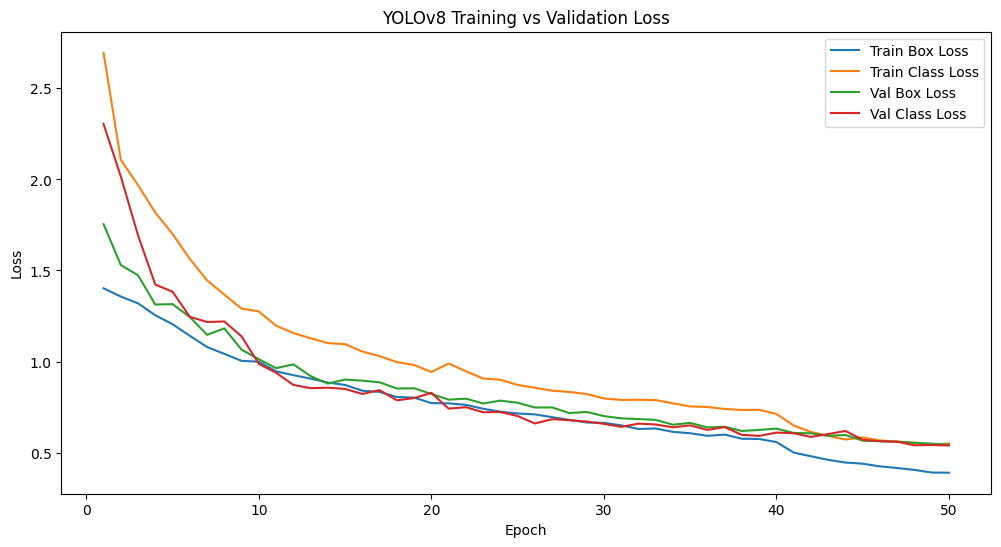

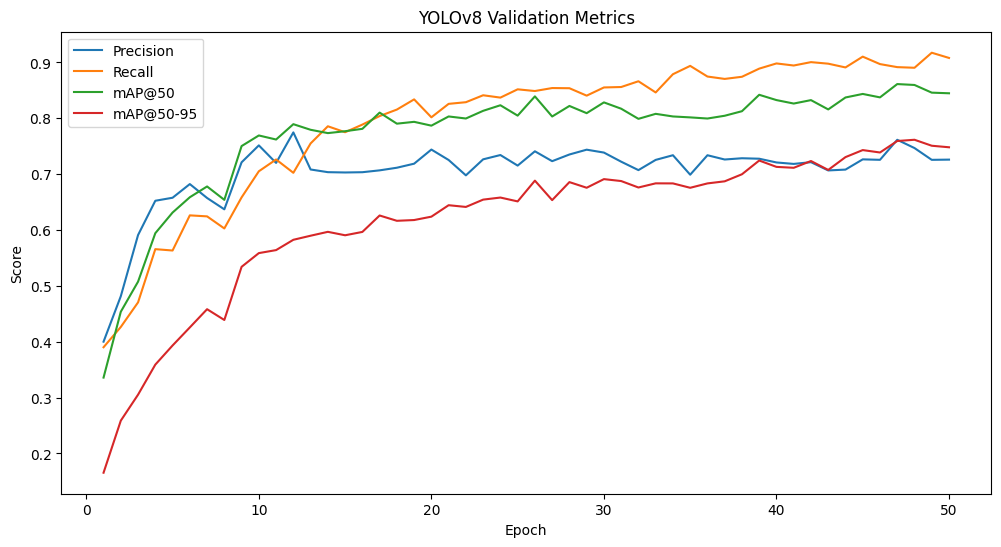

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to YOLO training results (change if needed)
results_dir = "runs/detect/currency_detector_1"
results_file = os.path.join(results_dir, "results.csv")

# Load results
df = pd.read_csv(results_file)

# Plot training & validation losses
plt.figure(figsize=(12,6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLOv8 Training vs Validation Loss")
plt.legend()
plt.show()

# Plot accuracy metrics (Precision, Recall, mAP)
plt.figure(figsize=(12,6))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("YOLOv8 Validation Metrics")
plt.legend()
plt.show()

In [5]:
!

fatal: not a git repository (or any of the parent directories): .git
